## Домашнее задание №3

### Автор: Сергеев Константин Олегович

### Задание

In [1]:
## Добавление визуального входа в модель QWEN 0.5B

# - На датасете Flickr30k с использованием предобученного визуального энкодера
# (CLIP, ViT, BLIP) обучить адаптер для изображений.
# - Саму LLM и энкодер не размораживать.
# - DoD – падение лосса при обучении и примеры генерации описаний картинок на отложенном сете.

### Импортируем библиотеки

In [2]:
#!pip -qq install bert_score

In [4]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from transformers import ViTModel, ViTImageProcessor, AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments
import torch.nn.functional as F
from torch import nn, optim
from bert_score import score as bert_score
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [6]:
device = 'cuda:0'

### Загрузка предобученного визуального энкодера

In [7]:
image_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

for param in image_encoder.parameters():
    param.requires_grad = False

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Загрузка модели QWEN 0.5B

In [8]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
llm = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

for param in llm.parameters():
    param.requires_grad = False

### Формируем датасет из Flickr30k

In [9]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [10]:
#!unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/Flickr30k.zip" -d "Flickr30k"

In [11]:
class Flickr30kDataset(Dataset):
    def __init__(self, df):
        images = df['image'].values
        self.image_inputs = []
        for image_path in tqdm(images):
            image = Image.open(data_folder + 'Images/' + image_path).convert('RGB')
            input_values = image_processor(image, return_tensors="pt")
            self.image_inputs.append(input_values['pixel_values'][0])

        self.descriptions = df['caption'].values
        self.labels = []
        for description in tqdm(self.descriptions):
            tokenized = tokenizer(tokenizer.pad_token + description,
                                padding='max_length',
                                truncation=True,
                                max_length=128,
                                return_tensors="pt")
            tokenized_ids = tokenized['input_ids'][0]
            self.labels.append(tokenized_ids)

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        return self.image_inputs[idx], self.descriptions[idx], self.labels[idx]


data_folder = '/mnt/sdb/konsergeev/Flickr30k/'
df = pd.read_csv(data_folder + 'captions.txt')
df = df.groupby('image').sum().reset_index()  # объединяем все описания изображения в одно
df = df.sample(frac=1, random_state=42)

df_train = df[:-1000].reset_index(drop=True)
df_val = df[-1000:-500].reset_index(drop=True)
df_test = df[-500:].reset_index(drop=True)

train_dataset = Flickr30kDataset(df_train)
val_dataset = Flickr30kDataset(df_val)
test_dataset = Flickr30kDataset(df_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

100%|███████████████████████████████████████| 500/500 [00:00<00:00, 2005.83it/s]


### Определение визуального адаптера

In [12]:
class ImageAdapter(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, stride=2, padding=1):
        super(ImageAdapter, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=output_dim,
                               kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = x.permute(0, 2, 1)
        return x


adapter = ImageAdapter(input_dim=image_encoder.config.hidden_size,
                       output_dim=llm.config.hidden_size,
                       #kernel_size=3, stride=2, padding=1  # 99 векторов
                       kernel_size=7, stride=4, padding=3  # 50 векторов
                       #kernel_size=15, stride=8, padding=7  # 25 векторов
                       #kernel_size=31, stride=16, padding=15  # 13 векторов
                       #kernel_size=61, stride=31, padding=30  # 7 векторов
                       #kernel_size=121, stride=61, padding=60  # 4 вектора
                      ).to(device)

# тест
test_input = test_dataset[0][0].to(device)
test_image_features = image_encoder(test_input.unsqueeze(0)).last_hidden_state
adapted_features = adapter(test_image_features)
print(adapted_features.shape)
print(f'Количество векторов на изображение: {adapted_features.shape[1]}')

torch.Size([1, 50, 896])
Количество векторов на изображение: 50


### Обучение визуального адаптера

100%|███████████████████████████████████████████| 63/63 [04:03<00:00,  3.86s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Train Loss: 2.5762
Val Loss: 2.4959
Average Val BERTScore: 0.8432
Image 1:


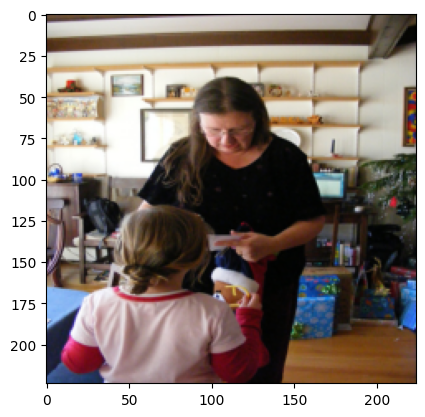

Generated Example 1: � ' A woman in a blue shirt and black pants is holding a baby . A woman with a baby in her arms . Woman holding a baby . Woman holding a baby . Mother holding a baby . Mother and child together . Mother and child together with a baby . Mother and child together with a baby girl . Mother and child together . Mother and child together with a baby boy . Mother and child together with a baby girl . Mother and child together with a baby boy . Mother and child together . Mother and child together with a baby girl . Mother and child together with a baby boy . Mother and child together . Mother and child together with a
Reference Example 1:  A middle-aged woman in a black dress stands facing a little girl who is holding a stuffed animal in blue hat . A mother and her daughter are enjoying their Christmas presents . A woman and a girl inside , near some gifts during the holidays . A woman and her gran-daughter open Christmas gifts . The older woman is talking to the child .

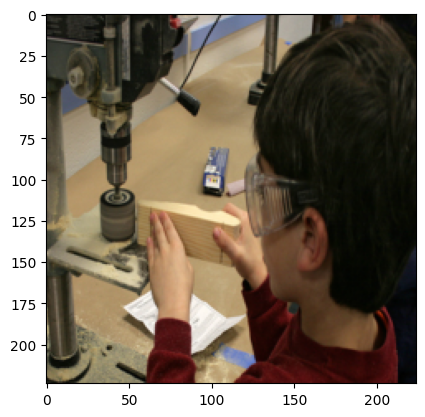

Generated Example 2: 豹子 , a man in a black shirt and jeans , a woman with a red scarf tied around her neck , and a young boy are all sitting on the ground . A man wearing a black shirt is holding a knife while another man holds a gun . A man in a black shirt is holding a knife while a man in a white shirt is holding a gun . A man in a black shirt is holding a knife while a man in a white shirt is holding a gun . A man in a black shirt is holding a knife while a man in a white shirt is holding a gun . A man in a black shirt is holding a knife while
Reference Example 2:  A small child uses a grinding machine while wearing safety glasses . A child sands the side of a block using a power tool . Young child using a wood machine . Child using a wood shop machine . A kid sands a piece of wood .
Image 3:


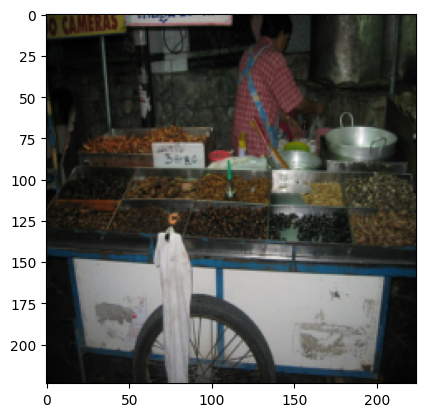

Generated Example 3: 丝绸制品 , a man in a blue shirt and jeans is holding a small bag of something . A man wearing a blue shirt and jeans is selling some silk products . A man in a blue shirt and jeans is selling some silk items . A man in a blue shirt and jeans is selling some silk fabric . A man in a blue shirt and jeans is selling some silk fabrics . A man in a blue shirt and jeans is selling some silk goods . A man in a blue shirt and jeans is selling some silk clothing . A man in a blue shirt and jeans is selling some silk fabrics . A man in a blue shirt and jeans is selling some
Reference Example 3:  A worker in a checkered shirt weighs out produce behind a stand that offers exotic foods . Variety is the spice of life no matter what the culture may be . A man prepares to sell items from his food cart . The street vendor is preparing food to be sold . A man in a red shirt preparing food .



100%|███████████████████████████████████████████| 63/63 [04:03<00:00,  3.87s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 2/3
Train Loss: 2.4084
Val Loss: 2.4292
Average Val BERTScore: 0.8497
Image 1:


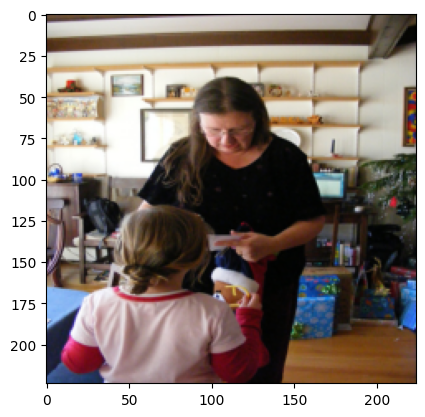

Generated Example 1:  = A woman in a red shirt and blue pants is holding a book while another woman holds a baby in her arms . A woman with a baby in her arms , wearing a red shirt and blue pants , is reading a book . A woman in a red shirt and blue pants is holding a baby in her arms . A woman in a red shirt and blue pants is holding a baby . A woman in a red shirt and blue pants is holding a baby . A woman in a red shirt and blue pants is holding a baby . A woman in a red shirt and blue pants is holding a baby . A woman in a red shirt and blue pants
Reference Example 1:  A middle-aged woman in a black dress stands facing a little girl who is holding a stuffed animal in blue hat . A mother and her daughter are enjoying their Christmas presents . A woman and a girl inside , near some gifts during the holidays . A woman and her gran-daughter open Christmas gifts . The older woman is talking to the child .
Image 2:


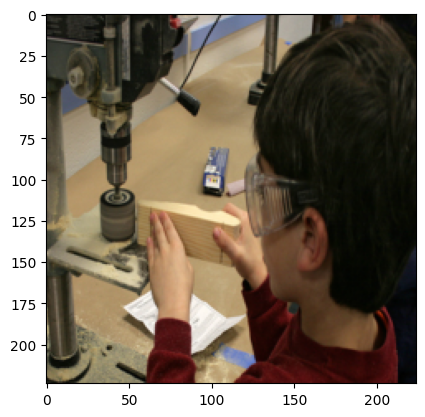

Generated Example 2: led up with a pair of black and white goggles on his head , wearing a blue shirt and glasses . A man in a suit is holding a small child in his arms . A young boy is looking at the camera while he holds a toy car . A man in a suit is holding a child in his arms . A man in a suit is holding a child in his arms . A man in a suit is holding a child in his arms . A man in a suit is holding a child in his arms . A man in a suit is holding a child in his arms . A man in a suit is holding a child in his arms .
Reference Example 2:  A small child uses a grinding machine while wearing safety glasses . A child sands the side of a block using a power tool . Young child using a wood machine . Child using a wood shop machine . A kid sands a piece of wood .
Image 3:


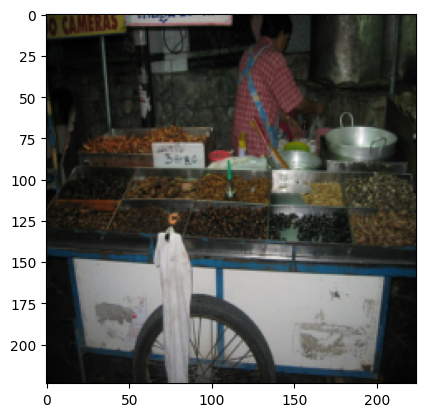

Generated Example 3: speculation of a man in a blue shirt and black pants , wearing a white apron . A man is standing on the street with his arms outstretched . A man is walking down the street . A man is sitting at a table selling food . A man is looking at a woman . A man is holding a bag . A man is walking down the street . A man is standing next to a store . A man is walking down the street . A man is sitting at a table selling food . A man is walking down the street . A man is standing next to a store . A man is walking down the street . A man
Reference Example 3:  A worker in a checkered shirt weighs out produce behind a stand that offers exotic foods . Variety is the spice of life no matter what the culture may be . A man prepares to sell items from his food cart . The street vendor is preparing food to be sold . A man in a red shirt preparing food .



100%|███████████████████████████████████████████| 63/63 [04:04<00:00,  3.88s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 3/3
Train Loss: 2.3490
Val Loss: 2.4067
Average Val BERTScore: 0.8482
Image 1:


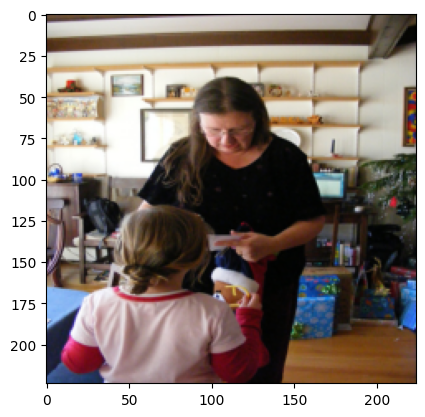

Generated Example 1: ed : A woman in a red shirt and blue pants is holding up a book while another woman holds it open . Two women are reading books together . Two women are sitting on the floor , one of them is reading a book . Two women are reading books together . Two women are reading books . Two women are reading books . Two women are reading books . Two women are reading books . Two women are reading books . Two women are reading books . Two women are reading books . Two women are reading books . Two women are reading books . Two women are reading books . Two women are reading books . Two women are reading books . Two women are
Reference Example 1:  A middle-aged woman in a black dress stands facing a little girl who is holding a stuffed animal in blue hat . A mother and her daughter are enjoying their Christmas presents . A woman and a girl inside , near some gifts during the holidays . A woman and her gran-daughter open Christmas gifts . The older woman is talking to the child 

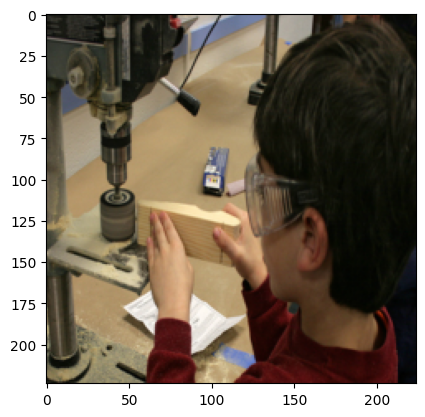

Generated Example 2:  . A young boy is sitting on a chair with his head resting on the back of another , while he holds a small toy in one hand and a pencil in the other . A little boy sits on a chair with his head resting on the back of another person . A little boy is sitting on a chair with his head resting on the back of another person . A little boy is sitting on a chair with his head resting on the back of another person . A little boy is sitting on a chair with his head resting on the back of another person . A little boy is sitting on a chair with his head resting on the back of another person
Reference Example 2:  A small child uses a grinding machine while wearing safety glasses . A child sands the side of a block using a power tool . Young child using a wood machine . Child using a wood shop machine . A kid sands a piece of wood .
Image 3:


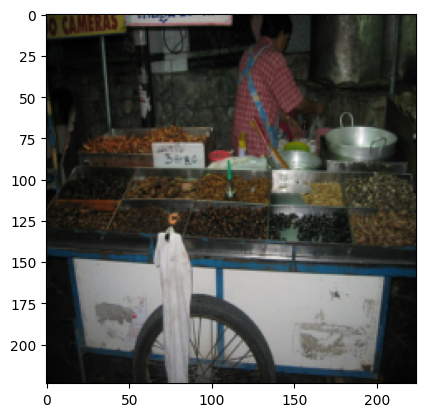

Generated Example 3: specimen of a man in a white shirt and black pants , with a large bag on his back . A man is walking down the street carrying a large bag . A man wearing a blue shirt and jeans walks down the street . A man in a red shirt carries a bag . A man in a blue shirt is walking down the street . A man in a blue shirt is walking down the street . A man in a blue shirt is walking down the street . A man in a blue shirt is walking down the street . A man in a blue shirt is walking down the street . A man in a blue shirt is walking down the street .
Reference Example 3:  A worker in a checkered shirt weighs out produce behind a stand that offers exotic foods . Variety is the spice of life no matter what the culture may be . A man prepares to sell items from his food cart . The street vendor is preparing food to be sold . A man in a red shirt preparing food .



In [13]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(adapter.parameters(), lr=1e-4)

epochs = 3

# Обучение
adapter.train()
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0

    for image_inputs, descriptions, labels in tqdm(train_loader):
        optimizer.zero_grad()
        image_inputs = image_inputs.to(device)
        labels = labels.to(device)

        # Пропуск через визуальный энкодер
        image_features = image_encoder(image_inputs).last_hidden_state

        # Пропуск через визуальный адаптер
        adapted_features = adapter(image_features)

        # Получение эмбедингов токенов описания
        text_features = llm._modules['model'].embed_tokens(labels)

        # Итоговая входная последовательность эмбедингов в LLM
        input_features = torch.cat([adapted_features, text_features], 1)

        # Пропуск через LLM
        outputs = llm(inputs_embeds=input_features)

        # Вычисление ошибки
        target_logints = outputs.logits.permute(0, 2, 1)[:, :, adapted_features.shape[1]:-1]
        target_labels = labels[:, 1:]
        loss = criterion(target_logints, target_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    adapter.eval()
    all_predictions = []
    all_references = []
    with torch.no_grad():
        for image_inputs, descriptions, labels in tqdm(val_loader):
            image_inputs = image_inputs.to(device)
            labels = labels.to(device)

            # Пропуск через визуальный энкодер
            image_features = image_encoder(image_inputs).last_hidden_state

            # Пропуск через визуальный адаптер
            adapted_features = adapter(image_features)

            # Получение эмбедингов токенов описания
            text_features = llm._modules['model'].embed_tokens(labels)

            # Итоговая входная последовательность эмбедингов в LLM
            input_features = torch.cat([adapted_features, text_features], 1)

            # Пропуск через LLM
            outputs = llm(inputs_embeds=input_features)

            # Вычисление ошибки
            target_logints = outputs.logits.permute(0, 2, 1)[:, :, adapted_features.shape[1]:-1]
            target_labels = labels[:, 1:]
            loss = criterion(target_logints, target_labels)

            val_loss += loss.item()

            # Генерация
            generated_ids = llm.generate(inputs_embeds=adapted_features, max_new_tokens=128, temperature=0.01)
            generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            all_predictions.extend(generated_texts)
            all_references.extend(descriptions)

    # Подсчёт среднего лосса и BERTScore
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    P, R, F1 = bert_score(all_predictions, all_references, lang='en')
    avg_bert_score = F1.mean().item()

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}")
    print(f"Average Val BERTScore: {avg_bert_score:.4f}")
    for i in range(3):
        print(f"Image {i+1}:")
        image_i = image_inputs[i].permute(1,2,0).detach().cpu()
        image_i = image_i - image_i.min()
        image_i = image_i / image_i.max()
        plt.imshow(image_i)
        plt.show()
        print(f"Generated Example {i+1}: {generated_texts[i]}")
        print(f"Reference Example {i+1}: {descriptions[i]}")
    print()

### Тесты количества подаваемых векторов в LLM

In [14]:
def eval_test():
    adapter.eval()
    test_loss = 0
    all_predictions = []
    all_references = []
    with torch.no_grad():
        for image_inputs, descriptions, labels in tqdm(test_loader):
            image_inputs = image_inputs.to(device)
            labels = labels.to(device)

            # Пропуск через визуальный энкодер
            image_features = image_encoder(image_inputs).last_hidden_state

            # Пропуск через визуальный адаптер
            adapted_features = adapter(image_features)

            # Получение эмбедингов токенов описания
            text_features = llm._modules['model'].embed_tokens(labels)

            # Итоговая входная последовательность эмбедингов в LLM
            input_features = torch.cat([adapted_features, text_features], 1)

            # Пропуск через LLM
            outputs = llm(inputs_embeds=input_features)

            # Вычисление ошибки
            target_logints = outputs.logits.permute(0, 2, 1)[:, :, adapted_features.shape[1]:-1]
            target_labels = labels[:, 1:]
            loss = criterion(target_logints, target_labels)

            test_loss += loss.item()

            # Генерация
            generated_ids = llm.generate(inputs_embeds=adapted_features, max_new_tokens=256, temperature=0.01)
            generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            all_predictions.extend(generated_texts)
            all_references.extend(descriptions)

    # Подсчёт среднего лосса и BERTScore
    avg_test_loss = test_loss / len(test_loader)
    P, R, F1 = bert_score(all_predictions, all_references, lang='en')
    avg_bert_score = F1.mean().item()

    print(f"Test Loss: {avg_val_loss:.4f}")
    print(f"Average Test BERTScore: {avg_bert_score:.4f}")
    for i in range(3):
        print(f"Image {i+1}:")
        image_i = image_inputs[i].permute(1,2,0).detach().cpu()
        image_i = image_i - image_i.min()
        image_i = image_i / image_i.max()
        plt.imshow(image_i)
        plt.show()
        print(f"Generated Example {i+1}: {generated_texts[i]}")
        print(f"Reference Example {i+1}: {descriptions[i]}")
    print()

#### 99 векторов

100%|███████████████████████████████████████████| 63/63 [07:50<00:00,  7.47s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Loss: 2.4319
Average Test BERTScore: 0.8308
Image 1:


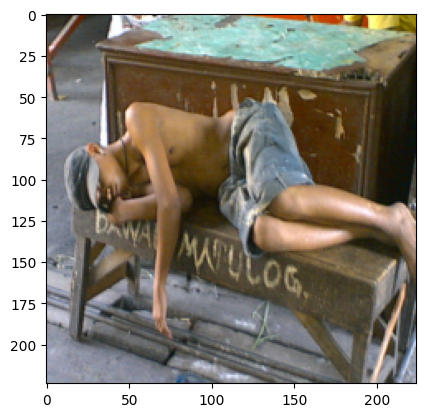

Generated Example 1:  A man in a white shirt is sitting on the floor with his arms crossed . A man sits on a chair , wearing a white shirt and holding a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair reading a book . A man is sitting on a chair re

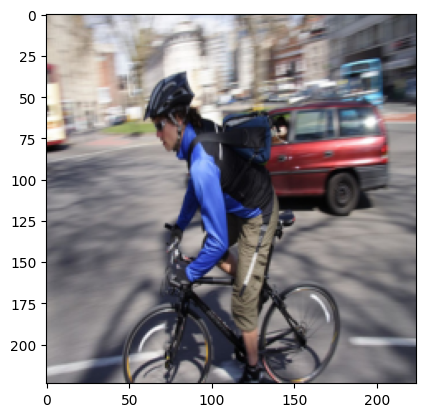

Generated Example 2:  A man in a red shirt and blue jeans is riding his bike down the street . A man wearing a red shirt and blue jeans is riding his bicycle down the street . A man in a red shirt rides his bicycle down the street . A man in a red shirt riding a bicycle . A man in a red shirt riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding a bicycle . A man riding

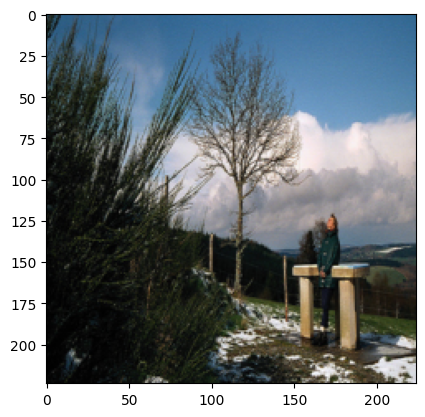

Generated Example 3:  A man in a blue shirt and black pants is standing on the side of a mountain . A man wearing a blue shirt stands next to a mountain . A man with a backpack is standing near a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt is standing next to a mountain . A man in a blue shirt i

In [15]:
eval_test()

#### 50 векторов

100%|███████████████████████████████████████████| 63/63 [07:47<00:00,  7.42s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Loss: 2.3697
Average Test BERTScore: 0.8352
Image 1:


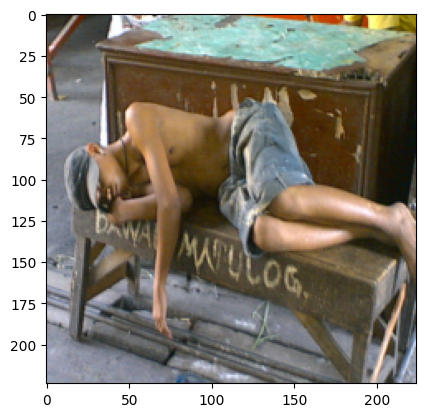

Generated Example 1:  is a young boy in a blue shirt and red shorts , sitting on the sidewalk with his legs crossed . A young boy sits on the sidewalk while wearing a blue shirt and red shorts . A young boy sits on the sidewalk with his legs crossed . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy sits on the sidewalk . A young boy s

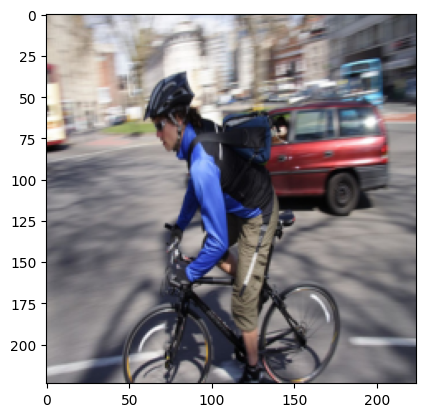

Generated Example 2: on a bike in the city with a red helmet and blue shirt on his head . A man is riding a bicycle down the street while wearing a red helmet . A man is riding a bicycle down the street . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is riding a bicycle . A man is ri

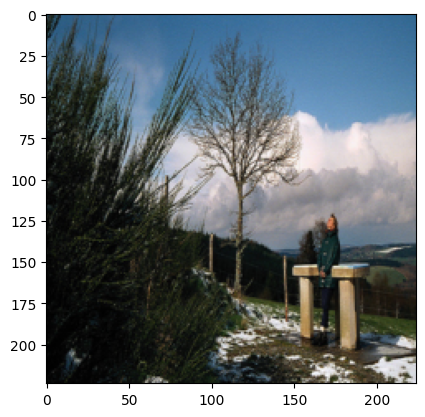

Generated Example 3: ment of a man in a jacket and hat , sitting on a rock overlooking the snow covered landscape . A man wearing a white jacket is standing on a rocky outcropping looking at something that appears to be snow . A man stands on a snowy hillside with his head tilted back . A man sits on a snowy mountain . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill . A man stands on a snowy hill

In [15]:
eval_test()

#### 25 векторов

100%|███████████████████████████████████████████| 63/63 [07:44<00:00,  7.38s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Loss: 2.3547
Average Test BERTScore: 0.8337
Image 1:


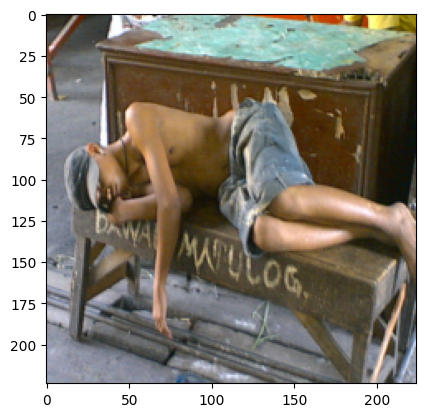

Generated Example 1:  There is a man sitting on the ground with his legs crossed . A man sits in a chair and has his legs crossed . A man is sitting on the floor , wearing a blue shirt . A man is lying down on the ground . A man is laying on the ground . A man is sleeping on the ground . A man is lying on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . A man is sleeping on the ground . 

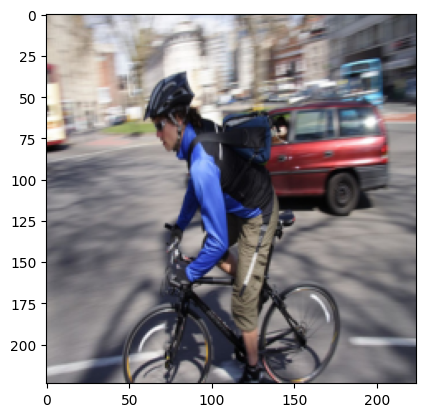

Generated Example 2:  One man in a blue shirt and helmet is riding his bike down the street . A man wearing a blue shirt and helmet rides his bicycle down the street . A man with a blue helmet on his bike is going down the street . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helmet is riding his bike . A man in a blue helm

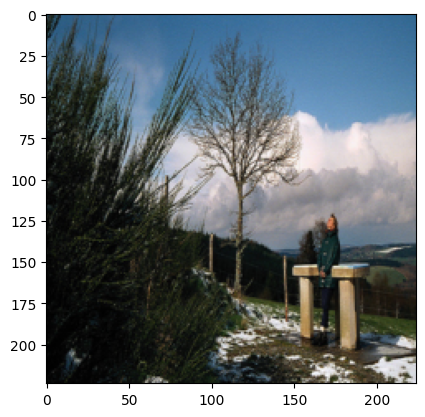

Generated Example 3:  2 people in a forest with trees and a mountain . Two men are standing on the side of a hill looking at something that is not there . Two men stand on a hillside overlooking a valley . Two men are sitting on a rock overlooking a lake . Two men sit on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overlooking a lake . Two men are sitting on a rock overloo

In [15]:
eval_test()

#### 13 векторов

100%|███████████████████████████████████████████| 63/63 [07:50<00:00,  7.47s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Loss: 2.3499
Average Test BERTScore: 0.8313
Image 1:


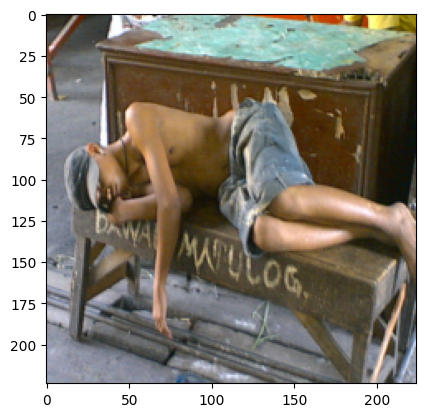

Generated Example 1: iums and a man in a blue shirt with a red bandage on his leg . A young boy is sitting on the ground , wearing a blue shirt and holding a red bandage . A young boy sits on the floor with a red bandage wrapped around his leg . A young boy is lying down on the ground with a red bandage wrapped around his leg . A young boy is laying on the ground with a red bandage wrapped around his leg . A young boy is lying on the ground with a red bandage wrapped around his leg . A young boy is lying on the ground with a red bandage wrapped around his leg . A young boy is lying on the ground with a red bandage wrapped around his leg . A young boy is lying on the ground with a red bandage wrapped around his leg . A young boy is lying on the ground with a red bandage wrapped around his leg . A young boy is lying on the ground with a red bandage wrapped around his leg . A young boy is lying on the ground with a red bandage wrapped around his leg . A young boy is lying on the ground wi

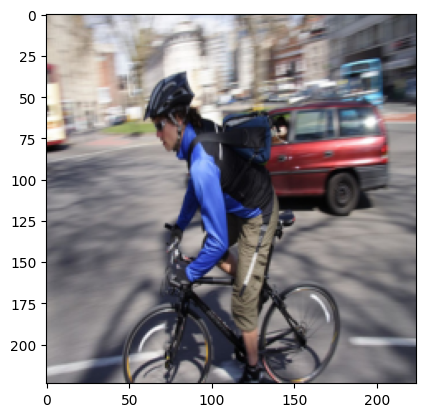

Generated Example 2: 弟骑自行车在街上 , with a red helmet on his head . A man wearing a red helmet is riding a bike down the street . A man in a red helmet rides his bicycle down the street . A man wearing a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike down the street . A man in a red helmet is riding his bike dow

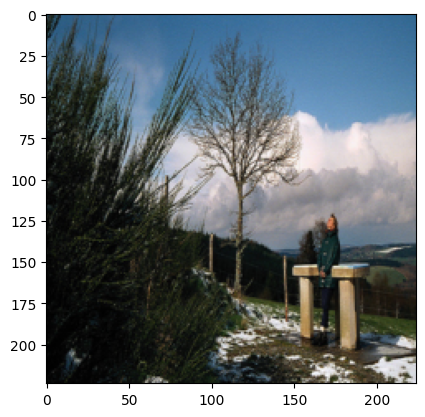

Generated Example 3: ower standing on a wooden platform with a view of the mountains . A man in a blue shirt and black pants is standing on a wooden platform overlooking a mountain . A man stands on a wooden platform looking at the mountains . A man stands on a wooden platform looking out over the mountains . A man stands on a wooden platform looking up at the mountains . A man stands on a wooden platform looking down at the mountains . A man stands on a wooden platform looking at the mountains . A man stands on a wooden platform looking at the mountains . A man stands on a wooden platform looking at the mountains . A man stands on a wooden platform looking at the mountains . A man stands on a wooden platform looking at the mountains . A man stands on a wooden platform looking at the mountains . A man stands on a wooden platform looking at the mountains . A man stands on a wooden platform looking at the mountains . A man stands on a wooden platform looking at the mountains . A man stan

In [15]:
eval_test()

#### 7 векторов

100%|███████████████████████████████████████████| 63/63 [07:48<00:00,  7.44s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Loss: 2.3786
Average Test BERTScore: 0.8332
Image 1:


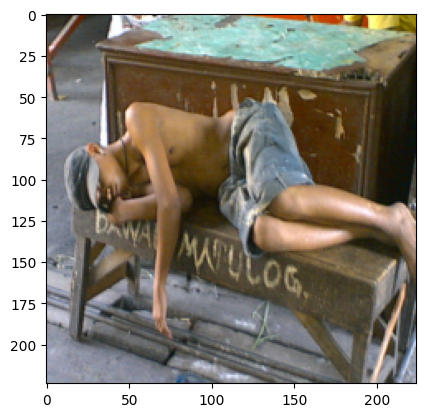

Generated Example 1: vid of a man with a black shirt and red shorts , sitting on the ground next to a trash can . A man in a black shirt is sitting on the ground near a trash can . A man sits on the ground next to a trash can . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitting on the ground . A man is sitt

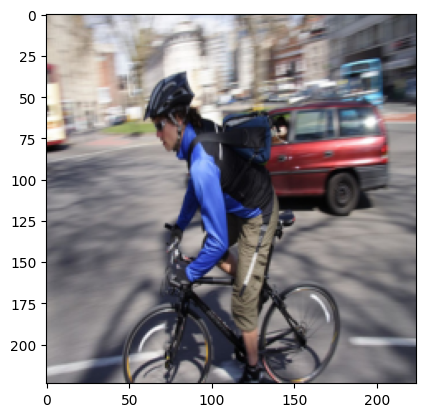

Generated Example 2: vid showing a man in a blue shirt and black pants riding his bike on the road . A man wearing a blue shirt is riding his bicycle down the street . A man with a blue shirt rides his bike down the street . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A man in a blue shirt is riding his bike . A

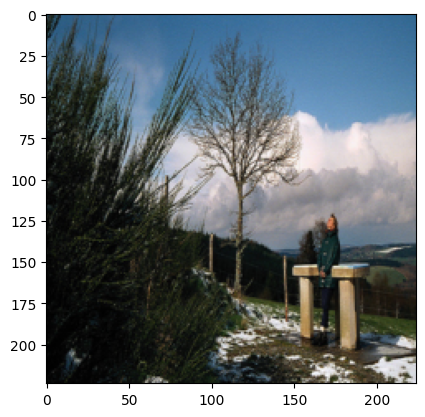

Generated Example 3: vids of people in a park with trees and mountains . A group of people are walking through the woods on a sunny day . People walk through a forested area . Several people walk through a wooded area . A group of people walk through a forest . A group of people walk through a wooded area . A group of people walk through a forest . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a wooded area . A group of people walk through a woode

In [15]:
eval_test()

#### 4 вектора

100%|███████████████████████████████████████████| 63/63 [07:42<00:00,  7.34s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Loss: 2.3637
Average Test BERTScore: 0.8267
Image 1:


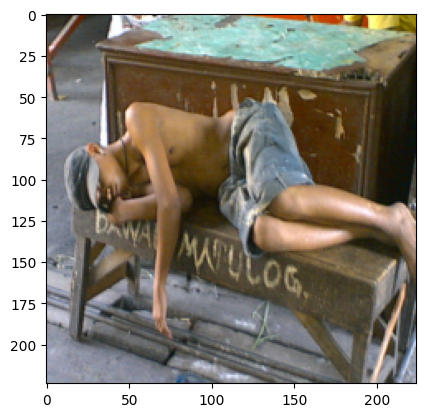

Generated Example 1: 功夫 play with a pair of wooden boards and a small piece of paper on the ground . A man is sitting in a chair , reading a book while another person sits next to him . A man is sitting on a bench reading a book . A man reads a book on a bench . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is reading a book . A man is


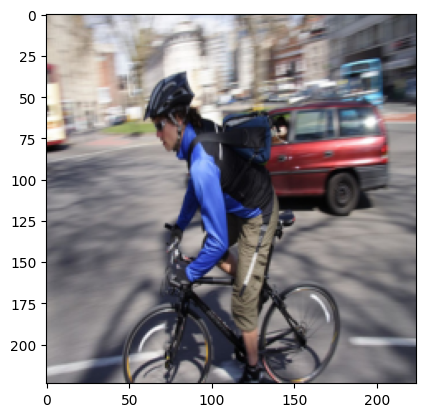

Generated Example 2: 功夫摩托车在街道上飞驰 , 而骑着的男子正在向后看 . A man in a black helmet is riding his motorcycle down the street . A man wearing a helmet rides his bike down the street . A man with a helmet is riding his bicycle . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike . A man in a helmet is riding his bike .
Refe

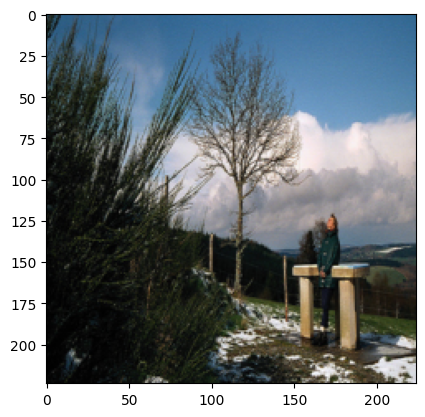

Generated Example 3: 功夫 of a man in a hat and jacket standing on the edge of a hill . A person wearing a hat stands on a rocky outcropping . A man with a hat stands on a rock face . A man is standing on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on a cliff . A man stands on a rock . A man stands on
Reference Example 3:  A person i

In [15]:
eval_test()

### Выводы

- Задача казалась гораздо легче на 1-ый взгляд, я её сильно недооценил, ведь когда дошла до реализации, оказалось не просто придумать, как всё таки передавать на вход LLM эмединги, а обучаться по токенам
- Видно, что система обучается с количеством эпох, Loss становится меньше, BertScore больше, а генерации лучше
- Результаты не идеальные, но и LLM всего 0.5B, которую мы при этом не размораживали
- В целом генерация получается тематически похожей на референс, что видно по неплохому BertScore
- Генерации получаются заметно длинне чем референс
- Иногда генерации получаются такие, что модель просто перечесляет все возможные описания изображений, такой локальный оптимум)
- После тестов разного количества входных векторов, оказалось, что лучшие результаты у 50 векторов на входе, что достигается при kernel_size=7, stride=4 и padding=3 у свёрточного слоя. Но важное уточнения, что помимо количество векторов на входе, так же менялось и количество параметров у адаптера
- В целом считаю проделанную работу и результат успешным

### Что можно сделать ещё

- Попробовать разморозить LLM
- Подобрать входной промт
- Протестить другую архитектуру адаптера, например несколько свёрток подряд